In [151]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib as mpl
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import to_rgba
import matplotlib.cm as cm
import xarray as xr
import numpy as np
from pathlib import Path
from matplotlib import cm, colors
import os
import pyproj
from pyproj import datadir
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
os.environ["PROJ_LIB"] = "/opt/homebrew/opt/proj/share/proj"
datadir.set_data_dir("/opt/homebrew/opt/proj/share/proj")

print(pyproj.datadir.get_data_dir())




/opt/homebrew/opt/proj/share/proj


In [138]:
# === Define paths ===
path_q_gis_in = '../data/camels/CAMELScl_boundaries_epsg4326.gpkg'
path_gw_results = '../analysis/4_GW_Q_memory/csv/gw_memory.csv'
path_q_results = '../analysis/4_GW_Q_memory/csv/q_memory.csv'
path_netcdf = '../data/other/elevation_srtm_v4.1_Chile_2000_1200m_epsg4326.nc'


# === Load the CSV files ===
gw_data = pd.read_csv(path_gw_results)
gw_attrib = pd.read_csv('../data/cr2sub/cr2sub_v1.1_attributes.csv').rename(columns={'cr2sub_id': 'well_id'})
q_data = pd.read_csv(path_q_results)
q_attrib = pd.read_csv('../data/camels/catchment_attributes.csv')
q_attrib['p_mean_cr2met_1979_2010'] = 365*q_attrib['p_mean_cr2met_1979_2010'] 

# === Load the GeoPackage files ===
gwl_gpkg = gpd.GeoDataFrame(
    gw_attrib,
    geometry=gpd.points_from_xy(gw_attrib['cr2sub_lon'], gw_attrib['cr2sub_lat']),
    crs='EPSG:4326'
)
q_gpkg = gpd.read_file(path_q_gis_in)

# === Normalize identifier columns so merges succeed ===
def normalize_numeric_id(series):
    numeric = pd.to_numeric(series, errors='coerce')
    return numeric.astype('Int64')

for frame, column in [(gwl_gpkg, 'well_id'), (gw_data, 'well_id'), (q_gpkg, 'gauge_id'), (q_data, 'gauge_id')]:
    frame[column] = normalize_numeric_id(frame[column])
    frame.dropna(subset=[column], inplace=True)
    frame[column] = frame[column].astype(str)

# === Load the NetCDF file ===
ds = xr.open_dataset(path_netcdf)
print(ds)
elevation = ds['elevation_srtm_v4.1_Chile_2000_1200m_epsg4326']

# === Load the region shapefile ===
path_shp = '../data/other/cl_regiones_geo/cl_regiones_geo.shp'
regions_gdf = gpd.read_file(path_shp)

# === Merge CSV with GeoPackage ===
gwl_merged = gwl_gpkg.merge(gw_data, left_on='well_id', right_on='well_id', how='left')
q_merged = q_gpkg.merge(q_data, left_on='gauge_id', right_on='gauge_id', how='left')

# === Save the new GeoPackages ===
gwl_gpkg = gwl_merged
q_gpkg = q_merged

# === Fixing Multi-part geometries ===
if q_gpkg.geom_type.isin(['MultiPolygon', 'MultiLineString']).any():
    q_gpkg = q_gpkg.explode(index_parts=False)

if gwl_gpkg.geom_type.isin(['MultiPolygon', 'MultiLineString']).any():
    gwl_gpkg = gwl_gpkg.explode(index_parts=False)

# === Remove any invalid geometries ===
q_gpkg = q_gpkg[q_gpkg.is_valid]
gwl_gpkg = gwl_gpkg[gwl_gpkg.is_valid]


# === bins for the map ===

# Step 1: Clean memory values
q_vals_clean = q_gpkg['q_memory'].dropna()
gw_vals_clean = gwl_gpkg['gw_memory'].dropna()

# Step 2: Define number of quantile bins for each
n_bins_q = 8
n_bins_gw = 12

q_bins = [0,2,6,9,12,20]
gw_bins = [24,36,48,60,72]


<xarray.Dataset> Size: 11MB
Dimensions:                                        (latitude: 3200,
                                                    longitude: 880)
Coordinates:
  * latitude                                       (latitude) float64 26kB -1...
  * longitude                                      (longitude) float64 7kB -7...
Data variables:
    elevation_srtm_v4.1_Chile_2000_1200m_epsg4326  (latitude, longitude) float32 11MB ...
    crs                                            int32 4B ...
Attributes:
    Conventions:  CF-1.4
    created_by:   R packages ncdf4 and terra (version 1.7-78)
    date:         2025-02-05 21:42:51


In [139]:
print(gw_vals_clean.max())
print(gw_vals_clean.min())
print(q_vals_clean.max())
print(q_vals_clean.min())


77.4883099532398
13.25317301269205
18.209752839011355
0.0


/var/folders/mm/nd9j2p7s4d1fmw46jbmnzdvr0000gn/T/ipykernel_20380/438195381.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_list = cm.get_cmap('inferno')(np.linspace(1, 0, len(bins) - 1))
/var/folders/mm/nd9j2p7s4d1fmw46jbmnzdvr0000gn/T/ipykernel_20380/438195381.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


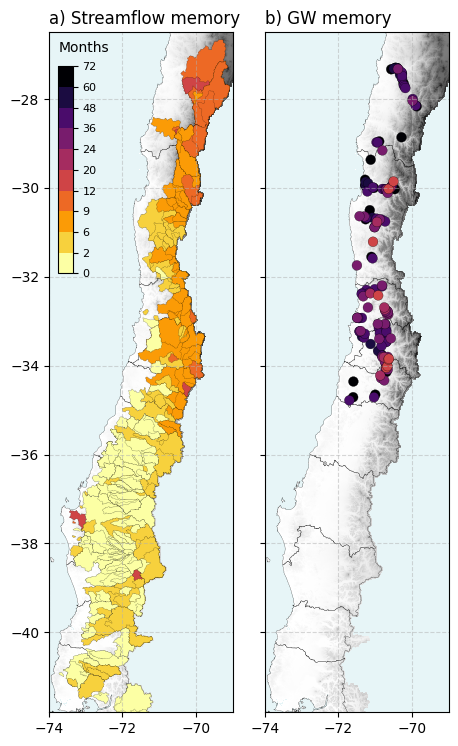

In [156]:
######### MAP HYDROLOGICAL MEMORY #########

# q_bins = np.quantile(q_vals_clean, np.linspace(0, 1, n_bins_q + 1))
# gw_bins = np.quantile(gw_vals_clean, np.linspace(0, 1, n_bins_gw + 1))

# Step 4: Merge, round, and ensure uniqueness
bins = np.round(np.unique(np.concatenate([q_bins, gw_bins])), 2)
bins[0] = 0  # ensure first bin starts at 0
cmap_list = cm.get_cmap('inferno')(np.linspace(1, 0, len(bins) - 1))
cmap = ListedColormap(cmap_list)
norm = BoundaryNorm(bins, cmap.N)
boundaries = bins

# labels = [str(b) for b in bins[:-1]]  # Exclude the last bin
# tick_positions = bins[:-1]            # Exclude the last bin

labels = [str(b) for b in bins]  # Exclude the last bin
tick_positions = bins            # Exclude the last bin


# === Map hydro memory values to bin indices using (a, b] logic ===
q_gpkg['bin_idx'] = pd.cut(
    q_gpkg['q_memory'],
    bins=bins,
    right=True,            # (a, b] intervals
    include_lowest=False,
    labels=False
)

gwl_gpkg['bin_idx'] = pd.cut(
    gwl_gpkg['gw_memory'],
    bins=bins,
    right=True,
    include_lowest=False,
    labels=False
)


# === Order by area (smallest on top) ===
# q_gpkg = q_gpkg.sort_values(by='area', ascending=True)
q_gpkg = q_gpkg.sort_values(by='area', ascending=False)
gwl_gpkg = gwl_gpkg.sort_values(by='gw_memory', ascending=False)

# === Define the bounding box (Chile region) ===
min_lon, max_lon = -74, -69
min_lat, max_lat = -41.8, -26.5
gwl_gpkg = gwl_gpkg[(gwl_gpkg.geometry.y <= max_lat) & (gwl_gpkg.geometry.y >= min_lat)]
q_gpkg = q_gpkg.cx[min_lon:max_lon, min_lat:max_lat]
elevation = elevation.sel(longitude=slice(min_lon, max_lon), latitude=slice(max_lat, min_lat))

# === Define the figure and axes (side by side) ===
fig = plt.figure(figsize=(12, 8))

width = 0.4
height = 0.85
x1 = 0.05
x2 = x1 + width - 0.22
x3 = x2 + width - 0.18

# === Create axes with manual placement ===
ax1 = fig.add_axes([x1, 0.1, width, height])  # [left, bottom, width, height]
ax2 = fig.add_axes([x2, 0.1, width, height])  # right panel slightly shifted
# ax3 = fig.add_axes([x3, 0.1, width, height])  # right panel slightly shifted

size_pt = 50

# === Plot blue ocean background ===
ax1.set_facecolor(to_rgba('powderblue', 0.3))
ax2.set_facecolor(to_rgba('powderblue', 0.3))

# === Plot the NetCDF elevation data ===
elevation.plot(ax=ax1, cmap='Greys', alpha=1, add_colorbar=False)
elevation.plot(ax=ax2, cmap='Greys', alpha=1, add_colorbar=False)

regions_gdf.plot(ax=ax1, edgecolor='black', facecolor='none', linewidth=0.2, alpha=0.8)
regions_gdf.plot(ax=ax2, edgecolor='black', facecolor='none', linewidth=0.2, alpha=0.8)

q_gpkg.plot(ax=ax1, column='bin_idx', cmap=cmap, norm=plt.Normalize(vmin=0, vmax=len(labels)-1),
            alpha=1, edgecolor='black', linewidth=0.1, label='Streamflow Memory')


gwl_gpkg.plot(ax=ax2, column='bin_idx', cmap=cmap, norm=plt.Normalize(vmin=0, vmax=len(labels)-1),
              markersize=size_pt, alpha=1, edgecolor='black', linewidth=0.2, label='Groundwater Memory')

# === Add titles ===
ax1.set_title('a) Streamflow memory', fontsize = 12, loc='left')
ax2.set_title('b) GW memory', fontsize = 12, loc='left')
ax2.set_yticklabels('')

# === Common colorbar ===
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cax_cbar = inset_axes(ax1, width="8%", height="35%", loc='upper left',
                      bbox_to_anchor=(0.05, 0.08, 1, .87), bbox_transform=ax1.transAxes, borderpad=0)

cbar = plt.colorbar(sm, cax=cax_cbar, orientation='vertical')
cbar.ax.set_title("Months", fontsize = 10, loc='left', pad=10)
cbar.ax.tick_params(labelsize=8)


# # === Set the labels correctly ===
cbar.ax.set_yticks(bins)
cbar.ax.set_yticklabels([f"{b:g}" for b in bins])
# cbar.ax.set_title("Months", fontsize = 10, loc='left', pad=10)

# === Remove axis labels and ticks ===
for ax in [ax1, ax2]:
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.grid(True, linestyle='--', alpha=0.5)

    # === Save the figure ===
plt.tight_layout()
plt.savefig('Fig_maps_GW_Q_memory.png', dpi=300, bbox_inches='tight')
plt.show()


In [141]:
# === Prepare data for boxplots ===
labels = ['Low', 'Medium', 'High']

def compute_monotonic_bins(series, n_bins):
    quantiles = np.linspace(0, 1, n_bins + 1)
    values = np.quantile(series, quantiles)
    eps = 1e-6
    for idx in range(1, len(values)):
        if values[idx] <= values[idx - 1]:
            values[idx] = values[idx - 1] + eps
            eps *= 10
    return values

def make_grouped_dataframe(data, attrib, id_col, column_map, prefix):
    frame = data.merge(attrib[[id_col] + list(column_map.values())], on=id_col, how='left')
    prefix_bins = {}
    for group_key, column in column_map.items():
        series = frame[column].dropna()
        if series.empty:
            bins = np.array([0.0, 1.0, 2.0, 3.0])
        else:
            bins = compute_monotonic_bins(series, len(labels))
        frame[f"{group_key}_group"] = pd.cut(frame[column], bins=bins, labels=labels, include_lowest=True)
        prefix_bins[f"{prefix}_{group_key}"] = {labels[i]: (float(bins[i]), float(bins[i + 1])) for i in range(len(bins) - 1)}
    return frame, prefix_bins

q_attributes = q_attrib[['gauge_id', 'p_mean_cr2met_1979_2010', 'frac_snow_cr2met_1979_2010', 'aridity_cr2met_1979_2010']].copy()
q_attributes['gauge_id'] = q_attributes['gauge_id'].astype(str)


q_box_df, q_group_bins = make_grouped_dataframe(
    q_data,
    q_attributes,
    'gauge_id',
    {
        'precip': 'p_mean_cr2met_1979_2010',
        'snow': 'frac_snow_cr2met_1979_2010',
        'aridity': 'aridity_cr2met_1979_2010',
    },
    prefix='q'
)

gw_attributes = gw_attrib[['well_id', 'cr2sub_camels_pr_yr', 'cr2sub_camels_sf', 'cr2sub_camels_aridity']].copy()
gw_attributes['well_id'] = gw_attributes['well_id'].astype(str)
gw_box_df, gw_group_bins = make_grouped_dataframe(
    gw_data,
    gw_attributes,
    'well_id',
    {
        'precip': 'cr2sub_camels_pr_yr',
        'snow': 'cr2sub_camels_sf',
        'aridity': 'cr2sub_camels_aridity',
    },
    prefix='gw'
)

group_bins = {**q_group_bins, **gw_group_bins}


In [142]:
# === Additional boxplots by precipitation, aridity, and snow fraction ===
import matplotlib.ticker as mticker


palette_lookup = {
    'precip': ['lightcyan','lightskyblue', 'dodgerblue'],
    'snow': ['lightcyan','lightskyblue', 'dodgerblue'],
    'aridity': ['lightgoldenrodyellow', 'gold', 'darkorange'],
}

def build_tick_labels(bin_key, categories, decimals):
    interval_map = group_bins.get(bin_key, {})
    labels_with_ranges = []
    fmt = f"{{:.{decimals}f}}"
    for cat in categories:
        interval = interval_map.get(cat)
        if interval:
            lower, upper = interval
            labels_with_ranges.append(f"{cat}\n[{fmt.format(lower)} - {fmt.format(upper)}]")
        else:
            labels_with_ranges.append(cat)
    return labels_with_ranges


def resolve_palette(bin_key):
    if 'precip' in bin_key:
        return palette_lookup['precip']
    if 'snow' in bin_key:
        return palette_lookup['snow']
    if 'aridity' in bin_key:
        return palette_lookup['aridity']
    return ['#cccccc'] * len(labels)

def plot_single_dataset_boxplots(data, value_col, group_specs, ylabel, save_path, align,hz,vs):
    n_groups = len(group_specs)
    # option horizontal align: 
    if align == 'h':
        fig, axes = plt.subplots(1, n_groups, figsize=(hz * n_groups, vs), sharey=True)
    
    if align == 'v':
        fig, axes = plt.subplots(n_groups, 1, figsize=(hz, vs * n_groups), sharey=True)
    
    # make the option vertical align: fig, axes = plt.subplots(1, n_groups, figsize=(single_dataset_base_width * n_groups, single_dataset_base_height), sharey=True)
    if n_groups == 1:
        axes = [axes]

    for idx, (ax, (group_col, bin_key, decimals, title)) in enumerate(zip(axes, group_specs)):
        subset = data.dropna(subset=[group_col, value_col])
        category_order = [cat for cat in labels if (subset[group_col] == cat).any()]
        if not category_order:
            ax.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=ax.transAxes)
            ax.set_xticks([])
            ax.set_ylabel('' if idx else ylabel)
            ax.set_title(title, fontsize=10)
            continue

        box_data = [subset.loc[subset[group_col] == cat, value_col] for cat in category_order]
        boxplot = ax.boxplot(box_data, showfliers=False, patch_artist=True)
        for element in ('boxes', 'whiskers', 'caps'):
            for line_obj in boxplot[element]:
                line_obj.set_linewidth(0.8)
        for median in boxplot['medians']:
            median.set_color('black')
            median.set_linewidth(0.8)
        palette = resolve_palette(bin_key)
        for patch, cat in zip(boxplot['boxes'], category_order):
            try:
                color = palette[labels.index(cat)]
            except (ValueError, IndexError):
                color = '#cccccc'
            patch.set_facecolor(color)
            patch.set_alpha(0.85)

        tick_labels = build_tick_labels(bin_key, category_order, decimals)
        ax.set_xticks(range(1, len(category_order) + 1))
        ax.set_xticklabels(tick_labels)
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f"{y:.0f}"))
        
        if align == 'h':
            if idx == 0:
                ax.set_ylabel(ylabel)
            else:
                ax.set_ylabel('')
                
        if align == 'v':
            ax.set_ylabel(ylabel,fontsize=12)
                
        ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='0.8')
        ax.set_axisbelow(True)
        # ax.set_title(title, fontsize=10)
        ax.set_title(title, fontsize=12, loc='left', x=0.02, y=0.85,
                     bbox=dict(facecolor='white', edgecolor='none', pad=3.0, alpha=0.8))

    plt.tight_layout()
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# # Streamflow memory figures
# q_group_specs = [
#     ('precip_group', 'q_precip', 0, 'Precipitation'),
#     ('snow_group', 'q_snow', 1, 'Snow fraction'),
#     ('aridity_group', 'q_aridity', 1, 'Aridity'),
# ]

# plot_single_dataset_boxplots(q_box_df, 'q_memory', q_group_specs, 
#                              'Streamflow memory', 
#                              'Fig_memory_boxplots_streamflow_h', 'h',3.5,3)
# plot_single_dataset_boxplots(q_box_df, 'q_memory', q_group_specs, 
#                              'Streamflow memory', 
#                              'Fig_memory_boxplots_streamflow_v', 'v',3.5,2.7)

# # Groundwater memory figures
# gw_group_specs = [
#     ('precip_group', 'gw_precip', 0, 'Precipitation'),
#     ('snow_group', 'gw_snow', 1, 'Snow fraction'),
#     ('aridity_group', 'gw_aridity', 1, 'Aridity'),
# ]
# plot_single_dataset_boxplots(gw_box_df, 'gw_memory', gw_group_specs, 
#                              'GW memory', 
#                              'Fig_memory_boxplots_gw_h', 'h',3.5,3)
# plot_single_dataset_boxplots(gw_box_df, 'gw_memory', gw_group_specs, 
#                              'GW memory', 
#                              'Fig_memory_boxplots_gw_v', 'v',3.5,2.7)





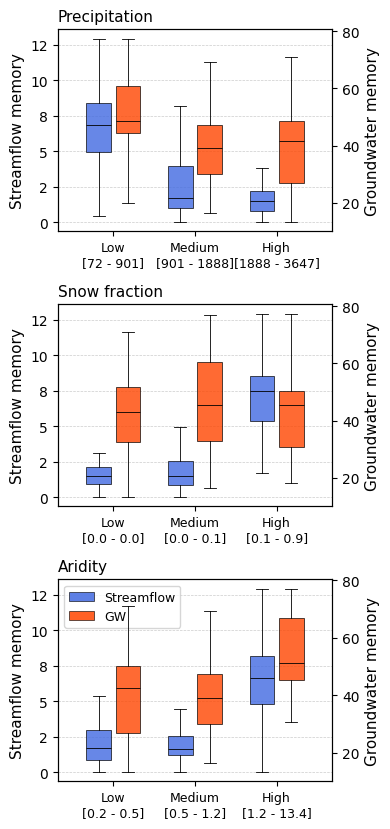

In [143]:

# === Combined boxplots for streamflow and groundwater memories ===
import numpy as np
from matplotlib.patches import Patch

combined_palette = {
    'streamflow': 'royalblue',
    'groundwater': 'orangered',
}

def plot_combined_dataset_boxplots(q_data, gw_data, q_value_col, gw_value_col, group_specs, q_ylabel, gw_ylabel, save_path):
    n_groups = len(group_specs)
    fig, axes = plt.subplots(n_groups, 1, figsize=(4, 2.8 * n_groups), sharey=True)
    if n_groups == 1:
        axes = [axes]
    else:
        axes = list(axes)

    for idx, (ax, (group_col, bin_key, decimals, title)) in enumerate(zip(axes, group_specs)):
        ax2 = ax.twinx()

        q_subset = q_data.dropna(subset=[group_col, q_value_col])
        gw_subset = gw_data.dropna(subset=[group_col, gw_value_col])
        category_order = [cat for cat in labels if (q_subset[group_col] == cat).any() or (gw_subset[group_col] == cat).any()]
        if not category_order:
            ax.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=ax.transAxes)
            ax.set_xticks([])
            if idx == 0:
                ax.set_ylabel(q_ylabel)
                ax2.set_ylabel(gw_ylabel)
            ax.set_title(title, fontsize=10)
            continue

        positions = np.arange(1, len(category_order) + 1)
        offset = 0.18

        q_box_data = [q_subset.loc[q_subset[group_col] == cat, q_value_col] for cat in category_order]
        gw_box_data = [gw_subset.loc[gw_subset[group_col] == cat, gw_value_col] for cat in category_order]

        q_boxplot = ax.boxplot(
            q_box_data,
            positions=positions - offset,
            widths=0.3,
            showfliers=False,
            patch_artist=True,
        )
        gw_boxplot = ax2.boxplot(
            gw_box_data,
            positions=positions + offset,
            widths=0.3,
            showfliers=False,
            patch_artist=True,
        )

        for element in ('boxes', 'whiskers', 'caps'):
            for line_obj in q_boxplot[element]:
                line_obj.set_linewidth(0.6)
            for line_obj in gw_boxplot[element]:
                line_obj.set_linewidth(0.6)

        for median in q_boxplot['medians']:
            median.set_color('black')
            median.set_linewidth(0.6)
        for median in gw_boxplot['medians']:
            median.set_color('black')
            median.set_linewidth(0.6)

        for patch in q_boxplot['boxes']:
            patch.set_facecolor(combined_palette['streamflow'])
            patch.set_alpha(0.8)
        for patch in gw_boxplot['boxes']:
            patch.set_facecolor(combined_palette['groundwater'])
            patch.set_alpha(0.8)

        tick_labels = build_tick_labels(bin_key, category_order, decimals)
        ax.set_xticks(positions)
        ax.set_xticklabels(tick_labels, fontsize = 9)
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f"{y:.0f}"))
        ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f"{y:.0f}"))
        ax.set_ylabel(q_ylabel, fontsize = 11)
        ax2.set_ylabel(gw_ylabel, fontsize = 11)

        # if idx == 0:
        #     ax.set_ylabel(q_ylabel)
        #     ax2.set_ylabel(gw_ylabel)
        # else:
        #     ax.set_ylabel('')
        #     ax2.set_ylabel('')
        ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='0.8')
        ax.set_axisbelow(True)
        ax2.grid(False)
        ax.set_title(title, fontsize=11,loc='left')
        ax2.set_xlim(ax.get_xlim())

        if idx == 2:
            legend_handles = [
                Patch(facecolor=combined_palette['streamflow'], edgecolor='black', linewidth = 0.5, alpha=0.85, label='Streamflow'),
                Patch(facecolor=combined_palette['groundwater'], edgecolor='black', linewidth = 0.5, alpha=0.85, label='GW'),
            ]
            ax.legend(handles=legend_handles, loc='upper left', fontsize=9)

    plt.tight_layout()
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

combined_group_specs = [
    ('precip_group', 'q_precip', 0, 'Precipitation'),
    ('snow_group', 'q_snow', 1, 'Snow fraction'),
    ('aridity_group', 'q_aridity', 1, 'Aridity'),
]
combined_boxplot_output = 'Fig_memory_boxplots_combined.png'
plot_combined_dataset_boxplots(
    q_box_df,
    gw_box_df,
    'q_memory',
    'gw_memory',
    combined_group_specs,
    'Streamflow memory',
    'Groundwater memory',
    combined_boxplot_output,
)


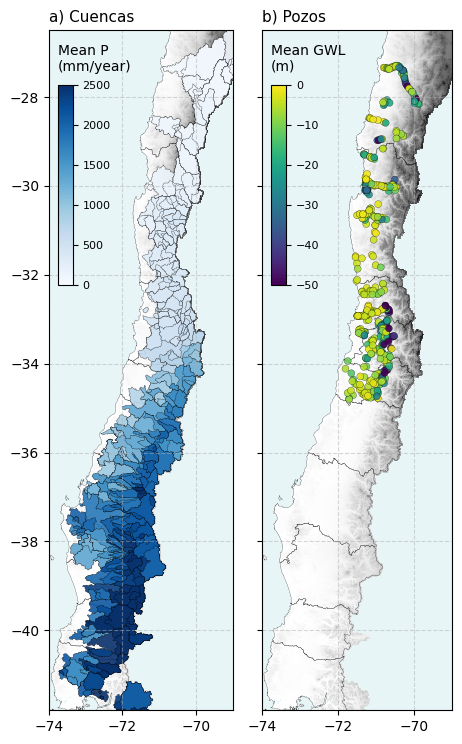

In [157]:

# === Study area overview maps ===


precip_column = 'p_mean_cr2met_1979_2010'
gwl_column = 'cr2sub_clean_mean_gwl'

def ensure_column(frame, base_name):
    if base_name in frame.columns:
        return base_name
    suffix_matches = [col for col in frame.columns if col.startswith(f"{base_name}_")]
    if suffix_matches:
        frame[base_name] = frame[suffix_matches[0]]
        return base_name
    return None

precip_attrs = q_attrib[['gauge_id', precip_column]].copy()
precip_attrs['gauge_id'] = precip_attrs['gauge_id'].astype(str)
q_precip_map = q_gpkg.copy()
if 'gauge_id' in q_precip_map.columns:
    q_precip_map['gauge_id'] = q_precip_map['gauge_id'].astype(str)
    q_precip_map = q_precip_map.merge(precip_attrs, on='gauge_id', how='left')
precip_col_name = ensure_column(q_precip_map, precip_column)

gw_attrs_available = gwl_column in gw_attrib.columns
if gw_attrs_available:
    gw_attrs = gw_attrib[['well_id', gwl_column]].copy()
    gw_attrs['well_id'] = gw_attrs['well_id'].astype(str)
else:
    gw_attrs = gw_attrib[['well_id']].copy()
    gw_attrs['well_id'] = gw_attrs['well_id'].astype(str)
gw_map = gwl_gpkg.copy()
if 'well_id' in gw_map.columns:
    gw_map['well_id'] = gw_map['well_id'].astype(str)
    gw_map = gw_map.merge(gw_attrs, on='well_id', how='left')
gw_col_name = ensure_column(gw_map, gwl_column)

fig = plt.figure(figsize=(12, 8))

width = 0.4
height = 0.85
x1 = 0.05
x2 = x1 + width - 0.22

ax1 = fig.add_axes([x1, 0.1, width, height])
ax2 = fig.add_axes([x2, 0.1, width, height])

for axis in (ax1, ax2):
    axis.set_facecolor(to_rgba('powderblue', 0.3))
    elevation.plot(ax=axis, cmap='Greys', alpha=1, add_colorbar=False)
    regions_gdf.plot(ax=axis, edgecolor='black', facecolor='none', linewidth=0.2, alpha=0.8)
    axis.set_xlabel('')
    axis.set_ylabel('')
    axis.grid(True, linestyle='--', alpha=0.5)

if precip_col_name is not None:
    precip_valid = q_precip_map.dropna(subset=[precip_col_name])
    if not precip_valid.empty:
        precip_norm = plt.Normalize(vmin=0, vmax=2500)
        precip_cmap = plt.cm.Blues
        precip_valid.plot(
            ax=ax1,
            column=precip_col_name,
            cmap=precip_cmap,
            norm=precip_norm,
            linewidth=0.2,
            edgecolor='black',
            alpha=0.9,
        )
        sm_precip = plt.cm.ScalarMappable(norm=precip_norm, cmap=precip_cmap)
        sm_precip.set_array([])
        cax_precip = inset_axes(ax1, width="8%", height="35%", loc='upper left',
                                bbox_to_anchor=(0.05, 0.08, 1, .84), bbox_transform=ax1.transAxes, borderpad=0)
        cbar_precip = plt.colorbar(sm_precip, cax=cax_precip, orientation='vertical')
        cbar_precip.ax.set_title('Mean P\n(mm/year)', fontsize=10, loc='left', pad = 10)
        cbar_precip.ax.tick_params(labelsize=8)
ax1.set_title('a) Cuencas', fontsize=11, loc='left')
ax2.set_yticklabels([])

if gw_col_name is not None:
    gw_valid = gw_map.dropna(subset=[gw_col_name])
    if not gw_valid.empty:
        gw_norm = plt.Normalize(vmin=-50, vmax=0)
        gw_cmap = plt.cm.viridis
        gw_valid.plot(
            ax=ax2,
            column=gw_col_name,
            cmap=gw_cmap,
            norm=gw_norm,
            markersize=25,
            edgecolor='black',
            linewidth=0.2,
            alpha=0.9,
        )
        sm_gw = plt.cm.ScalarMappable(norm=gw_norm, cmap=gw_cmap)
        sm_gw.set_array([])
        cax_gw = inset_axes(ax2, width="8%", height="35%", loc='upper left',
                            bbox_to_anchor=(0.05, 0.08, 1, .84), bbox_transform=ax2.transAxes, borderpad=0)
        cbar_gwl = plt.colorbar(sm_gw, cax=cax_gw, orientation='vertical')
        cbar_gwl.ax.set_title('Mean GWL\n(m)', fontsize=10, loc='left', pad = 10)
        cbar_gwl.ax.tick_params(labelsize=8)
ax2.set_title('b) Pozos', fontsize=11, loc='left')

plt.savefig('Fig_study_area_overview.png', dpi=300, bbox_inches='tight')
plt.show()
